In [7]:
import tensorflow as tf

# Set the paths to your dataset
train_dir = r"D:\Work\python\dl_clg\datasets\Flowers\train"
val_dir = r"D:\Work\python\dl_clg\datasets\Flowers\test"

# Load the training and validation datasets
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Get class names
class_names = train_ds.class_names
print("Classes:", class_names)


Found 3250 files belonging to 5 classes.
Using 2600 files for training.
Found 530 files belonging to 5 classes.
Using 106 files for validation.
Classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [17]:
# Load MobileNetV2 as the base model with pre-trained ImageNet weights
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height, img_width, 3),
                                               include_top=False,
                                               weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Add classification head
num_classes = len(class_names)
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')  # Output layer for flower classes
])


In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [19]:
# Train the model for 10 epochs
model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10


82/82 [==============================] - 41s 423ms/step - loss: 1.3813 - accuracy: 0.4446 - val_loss: 1.2417 - val_accuracy: 0.5094
Epoch 2/10
82/82 [==============================] - 32s 395ms/step - loss: 1.0456 - accuracy: 0.5958 - val_loss: 1.1692 - val_accuracy: 0.5660
Epoch 3/10
82/82 [==============================] - 30s 370ms/step - loss: 0.9474 - accuracy: 0.6488 - val_loss: 1.1081 - val_accuracy: 0.5377
Epoch 4/10
82/82 [==============================] - 30s 363ms/step - loss: 0.8773 - accuracy: 0.6685 - val_loss: 1.2053 - val_accuracy: 0.5377
Epoch 5/10
82/82 [==============================] - 29s 351ms/step - loss: 0.7912 - accuracy: 0.7085 - val_loss: 1.2086 - val_accuracy: 0.5943
Epoch 6/10
82/82 [==============================] - 39s 470ms/step - loss: 0.7434 - accuracy: 0.7342 - val_loss: 1.0878 - val_accuracy: 0.5660
Epoch 7/10
82/82 [==============================] - 34s 417ms/step - loss: 0.6724 - accuracy: 0.7627 - val_loss: 1.3668 - val_accuracy: 0.5377
Epoch 8/10

In [ ]:
# Save the model
model.save('flower_model.h5')

In [20]:
def load_and_preprocess_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Adjust for PNG if needed
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.image.convert_image_dtype(img, tf.float32)  # Scale to [0, 1]
    img = tf.expand_dims(img, axis=0)  # Add batch dimension
    return img
    

In [21]:
test_image_path = r"D:\Work\python\dl_clg\datasets\Flowers\test\daisy\daisy_9.jpg"  # Replace with your test image path
test_image = load_and_preprocess_image(test_image_path)

In [22]:
# Make predictions
import numpy as np
predictions = model.predict(test_image)
predicted_class = np.argmax(predictions, axis=1)

1/1 [==============================] - 1s 859ms/step


Predicted class: daisy


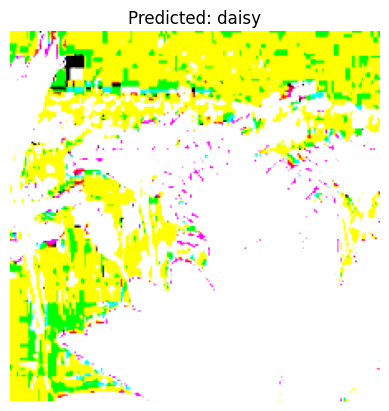

In [23]:
import matplotlib.pyplot as plt
# Display the result
print(f"Predicted class: {class_names[predicted_class[0]]}")

# Optional: Display the image
plt.imshow(tf.squeeze(test_image))
plt.axis('off')
plt.title(f'Predicted: {class_names[predicted_class[0]]}')
plt.show()